### Questions

- [x] Combien de documents un patient reçoit en moyenne ?
- Est-ce qu'un document est toujours une visite ? (un document une date différente (à vérifier)?)
- [x] Quel est le temps moyen de suivi par patient ?
- [x] Combien d’HPO différents sont associés à un patient ?
- Quelle est la longueur des textes associées au patient ?
- Y a-t-il des profils “faibles documentation” vs “forte documentation” ?
- L’âge des patients influence-t-il le volume documentaire ?
- Comment évolue l'ajout de nouveaux symptômes au cours du temps ?
- À quel moment les principaux HPO sont-ils mentionnés (début vs fin) ?
- Y a-t-il des patterns temporels dans les visites ? (ex. “toutes 6 semaines”)
- Le rythme de documentation est-il corrélé à la sévérité clinique ?
- Quels HPO co-apparaissent fréquemment ensemble (co-occurrence) ?
- Certains symptômes précèdent-ils systématiquement d’autres ?
- Quels sont les mots ou HPO les plus informatifs dans le corpus ? Est-ce qu'on peut le calculer par rapport aux bases de données de maladies rares ? 
- Une partie de l’information est-elle répétée à chaque visite ?
- LDA


- Column sparkline rangé par date avec production d'HPO par document ou production du nouveaux termes HPO

Questions plus robustes à tester
Peut-on détecter des “chemins cliniques” organisationnels ?
Peut-on construire un score de complexité clinique ?
Peut-on identifier des cas rares ou atypiques ?

In [4]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("simulated_patient_level_df.csv", sep=";")

In [12]:
import ast
import pandas as pd
import numpy as np

# --- 1. Colonnes date ---
date_cols = ["first_doc_date", "last_doc_date"]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# --- 2. Colonnes numériques ---
num_cols = [
    # identifiant interne éventuel
    "PATIENT_INT_ID",

    # texte / docs
    "n_documents",
    "total_words",
    "mean_words_per_doc",
    "max_words_doc",
    "total_sentences",
    "mean_avg_sentence_len_words",

    # HPO (nouvelles colonnes et alias)
    "n_hpo_full_list",
    "n_hpo_unique",
    "hpo_total_per_doc",
    "hpo_unique_per_doc",
    "hpo_per_sentence",
    "hpo_per_1k_words",
    # alias pour compatibilité si présents
    "total_hpo_mentions",
    "n_hpo_codes",

    # autres
    "n_document_types",
    "n_units",
    "n_authors",
    "patient_age_first",
    "patient_age_last",
    "followup_days",
    "docs_per_year",
    "n_variants",
]

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# --- 3. Colonnes de listes (variants + HPO) : ast.literal_eval ---
variant_list_cols = [
    "transcript_from_ehop",
    "transcript",
    "transcript_no_version",
    "chr",
    "pos",
    "ref",
    "alt",
    "var_id",
    "transcript_nm",
    "gene_symbol",
    "gene_hgnc_id",
    "acmg_classification",
    "acmg_criteria",
    "clinvar_classification",
    "clinvar_review_status",
]

# nouvelles colonnes de listes HPO
hpo_list_cols = [
    "HPO_full_list",
    "HPO_unique_list",
]

list_cols = variant_list_cols + hpo_list_cols

def parse_list_or_keep(x):
    """
    - si x est déjà une liste -> on le garde
    - si x est NaN -> on renvoie une liste vide
    - si x est une str qui ressemble à une liste -> ast.literal_eval
    - sinon -> on le met dans une liste singleton
    """
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    if isinstance(x, str):
        s = x.strip()
        # chaîne comme "[]" -> liste vide
        if s == "" or s == "[]":
            return []
        try:
            val = ast.literal_eval(s)
            # parfois literal_eval renvoie un scalaire
            if isinstance(val, list):
                return val
            else:
                return [val]
        except (ValueError, SyntaxError):
            # ce n’est pas une représentation de liste -> on encapsule
            return [x]
    # autres types (int, float, etc.)
    return [x]

for col in list_cols:
    if col in df.columns:
        df[col] = df[col].apply(parse_list_or_keep)

# --- 4. Colonnes catégorielles / texte ---
cat_cols = [
    "PATIENT_ID_HEX",
    "patient_label",
]
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype("string")

# Petit check
print(df.dtypes)
print("\nExemple de ligne (listes variants + HPO) :")
cols_to_show = [c for c in list_cols if c in df.columns]
print(df.iloc[2][cols_to_show].to_dict())


PATIENT_ID_HEX                 string[python]
n_documents                             int64
n_visits                                int64
first_doc_date                 datetime64[ns]
last_doc_date                  datetime64[ns]
total_words                             int64
mean_words_per_doc                    float64
max_words_doc                           int64
total_sentences                         int64
mean_avg_sentence_len_words           float64
n_hpo_full_list                         int64
n_hpo_unique                            int64
hpo_total_per_doc                     float64
hpo_unique_per_doc                    float64
hpo_per_sentence                      float64
hpo_per_1k_words                      float64
total_hpo_mentions                      int64
n_hpo_codes                             int64
HPO_full_list                          object
HPO_unique_list                        object
n_document_types                        int64
n_units                           

### Histogramme des âges moyens en arrivant au service

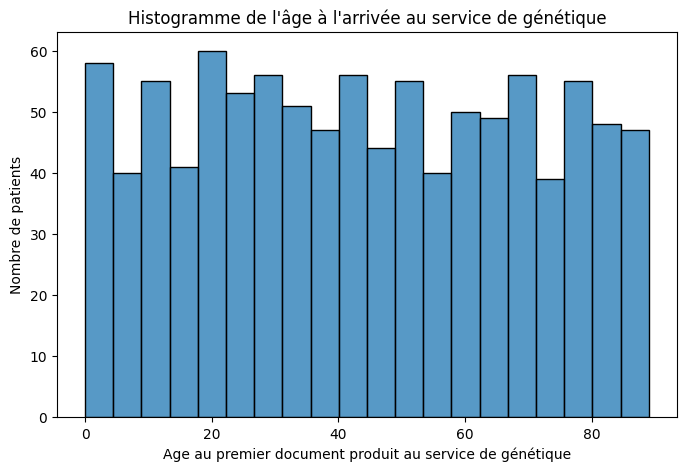

In [ ]:
x = df["patient_age_first"]

plt.figure(figsize=(8,5))
sns.histplot(x, bins=20, kde=False)

# ticks tous les 5 ans par exemple
min_age, max_age = x.min(), x.max()
plt.xticks(np.arange(0, max_age+1, 5))

plt.title("Histogramme de l'âge à l'arrivée au service de génétique")
plt.xlabel("Age au premier document produit au service de génétique")
plt.ylabel("Nombre de patients")
plt.tight_layout()
plt.show()


#### Combien de documents un patient reçoit en moyenne ?

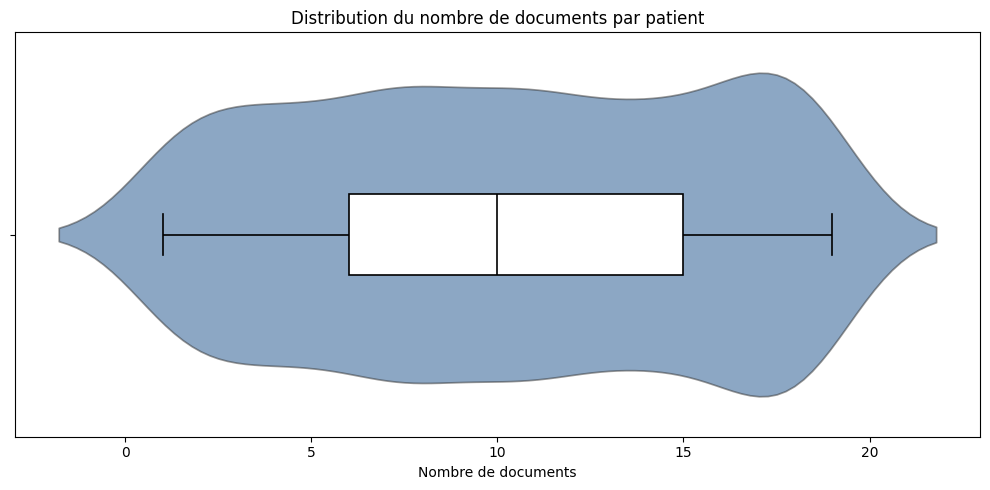

In [13]:
plt.figure(figsize=(10, 5))

# Couleur demandée
violin_color = "#08519c"
box_edge_color = "#000000"  # bordure boxplot noire
box_face_color = "#ffffff"  # intérieur blanc

# Violin plot
sns.violinplot(
    data=df,
    x="n_documents",
    inner=None,
    color=violin_color,
    alpha=0.5  # transparence
)

# Boxplot superposé
sns.boxplot(
    data=df,
    x="n_documents",
    width=0.2,
    fliersize=2,
    linewidth=1.2,
    boxprops=dict(facecolor=box_face_color, edgecolor=box_edge_color),
    medianprops=dict(color=box_edge_color),
    whiskerprops=dict(color=box_edge_color),
    capprops=dict(color=box_edge_color),
)

plt.title("Distribution du nombre de documents par patient")
plt.xlabel("Nombre de documents")
plt.tight_layout()
plt.show()

### Quel est le nombre de mots totaux par patient ?

In [ ]:
plt.figure(figsize=(10, 5))

# Couleur demandée
violin_color = "#08519c"
box_edge_color = "#000000"  # bordure boxplot noire
box_face_color = "#ffffff"  # intérieur blanc

# Violin plot
sns.violinplot(
    data=df,
    x="n_documents",
    inner=None,
    color=violin_color,
    alpha=0.5  # transparence
)

# Boxplot superposé
sns.boxplot(
    data=df,
    x="n_documents",
    width=0.2,
    fliersize=2,
    linewidth=1.2,
    boxprops=dict(facecolor=box_face_color, edgecolor=box_edge_color),
    medianprops=dict(color=box_edge_color),
    whiskerprops=dict(color=box_edge_color),
    capprops=dict(color=box_edge_color),
)

plt.title("Distribution du nombre de documents par patient")
plt.xlabel("Nombre de documents")
plt.tight_layout()
plt.show()

### Quel est le temps moyen de suivi par patient ?

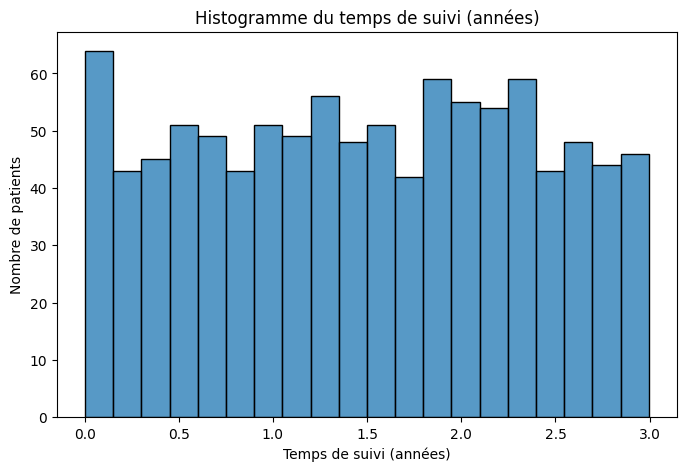

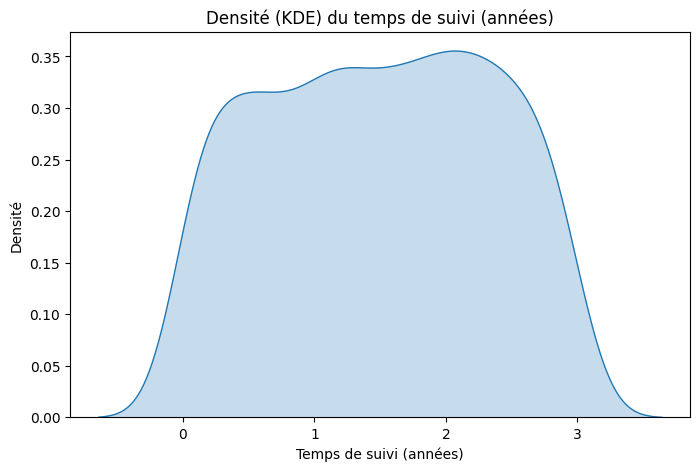

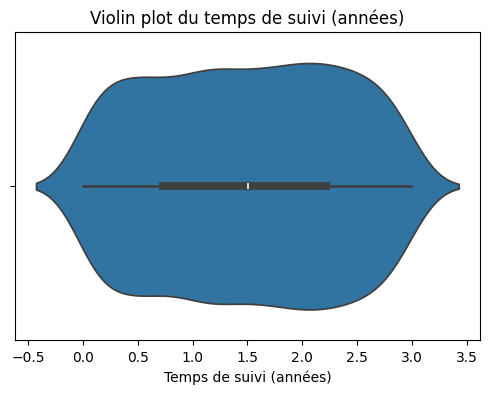

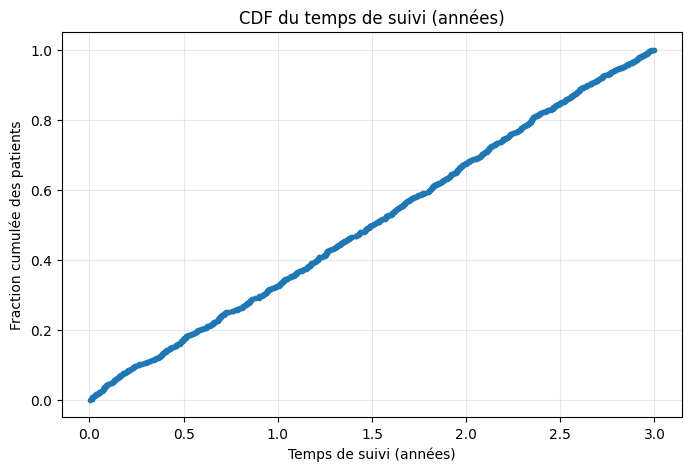

In [14]:
x = df["followup_days"] / 365.25  # en années
x = x


### HIstogramme
plt.figure(figsize=(8,5))
sns.histplot(x, bins=20, kde=False)
plt.title("Histogramme du temps de suivi (années)")
plt.xlabel("Temps de suivi (années)")
plt.ylabel("Nombre de patients")
plt.show()


### Kernel density
plt.figure(figsize=(8,5))
sns.kdeplot(x, fill=True)
plt.title("Densité (KDE) du temps de suivi (années)")
plt.xlabel("Temps de suivi (années)")
plt.ylabel("Densité")
plt.show()

#### Violin plot
plt.figure(figsize=(6,4))
sns.violinplot(x=x, orient="h")
plt.title("Violin plot du temps de suivi (années)")
plt.xlabel("Temps de suivi (années)")
plt.show()


### CDF
x_sorted = np.sort(x)
y = np.arange(1, len(x_sorted)+1) / len(x_sorted)

plt.figure(figsize=(8,5))
plt.plot(x_sorted, y, marker='.', linestyle='none')
plt.title("CDF du temps de suivi (années)")
plt.xlabel("Temps de suivi (années)")
plt.ylabel("Fraction cumulée des patients")
plt.grid(True, alpha=0.3)
plt.show()


### Combien d’HPO différents sont associés à un patient ?

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   PATIENT_ID_HEX               1000 non-null   string        
 1   n_documents                  1000 non-null   int64         
 2   n_visits                     1000 non-null   int64         
 3   first_doc_date               1000 non-null   datetime64[ns]
 4   last_doc_date                1000 non-null   datetime64[ns]
 5   total_words                  1000 non-null   int64         
 6   mean_words_per_doc           1000 non-null   float64       
 7   max_words_doc                1000 non-null   int64         
 8   total_sentences              1000 non-null   int64         
 9   mean_avg_sentence_len_words  1000 non-null   float64       
 10  n_hpo_full_list              1000 non-null   int64         
 11  n_hpo_unique                 1000 non-null  

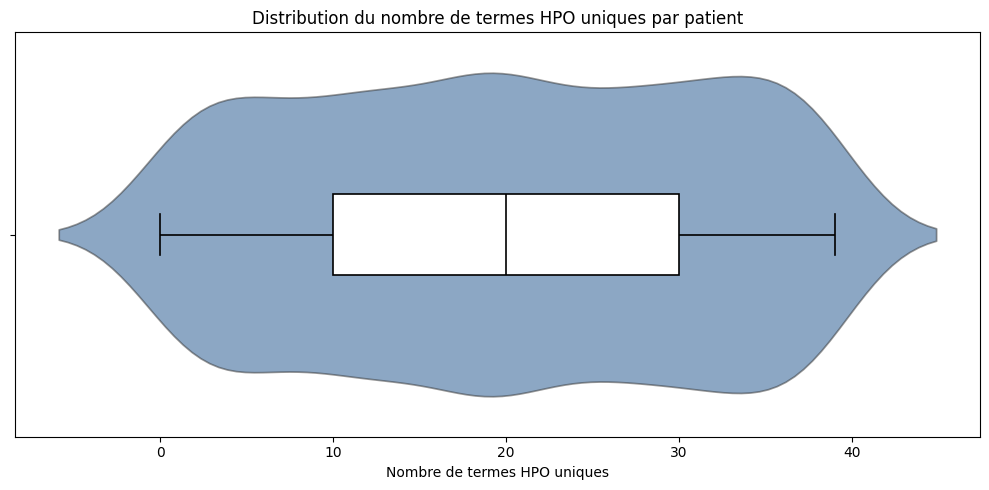

In [17]:
plt.figure(figsize=(10, 5))

# Couleur demandée
violin_color = "#08519c"
box_edge_color = "#000000"  # bordure boxplot noire
box_face_color = "#ffffff"  # intérieur blanc

# Violin plot
sns.violinplot(
    data=df,
    x="n_hpo_unique",
    inner=None,
    color=violin_color,
    alpha=0.5  # transparence
)

# Boxplot superposé
sns.boxplot(
    data=df,
    x="n_hpo_unique",
    width=0.2,
    fliersize=2,
    linewidth=1.2,
    boxprops=dict(facecolor=box_face_color, edgecolor=box_edge_color),
    medianprops=dict(color=box_edge_color),
    whiskerprops=dict(color=box_edge_color),
    capprops=dict(color=box_edge_color),
)

plt.title("Distribution du nombre de termes HPO uniques par patient")
plt.xlabel("Nombre de termes HPO uniques")
plt.tight_layout()
plt.show()

### Distribution du nombre totale de HPO mentionnés

In [ ]:
plt.figure(figsize=(10, 5))

# Couleur demandée
violin_color = "#08519c"
box_edge_color = "#000000"  # bordure boxplot noire
box_face_color = "#ffffff"  # intérieur blanc

# Violin plot
sns.violinplot(
    data=df,
    x="n_hpo_full_list",
    inner=None,
    color=violin_color,
    alpha=0.5  # transparence
)

# Boxplot superposé
sns.boxplot(
    data=df,
    x="n_hpo_full_list",
    width=0.2,
    fliersize=2,
    linewidth=1.2,
    boxprops=dict(facecolor=box_face_color, edgecolor=box_edge_color),
    medianprops=dict(color=box_edge_color),
    whiskerprops=dict(color=box_edge_color),
    capprops=dict(color=box_edge_color),
)

plt.title("Distribution du nombre de termes HPO uniques par patient")
plt.xlabel("Nombre de termes HPO uniques")
plt.tight_layout()
plt.show()

### Taux de redondance

La redondance R peut être définie comme : R = n_full / n_unique
où :

n_full=len(HPO_full_list)
nunique=len(HPO_unique_list)

Interprétation :
R → 1 ⇒ faible redondance
R >> 1 ⇒ beaucoup de répétitions du même code


D'autres variantes possibles : 
- Normalisée
- Entropie

In [29]:
from collections import Counter
import numpy as np

def shannon_entropy(full_list):
    if len(full_list) == 0:
        return 0.0
    print(full_list)
    counts = np.array(list(Counter(full_list).values())) # Décompte
    print(counts)
    p = counts / counts.sum()
    print(p)
    return -(p * np.log(p)).sum()

# Entropie de Shannon
# df["entropy_shannon"] = df["HPO_full_list"].apply(shannon_entropy)

## Taux de redondance normalisé
df["redundancy_ratio"] = df["n_hpo_full_list"] / df["n_hpo_unique"].replace(0, np.nan)
df["redundancy_norm"] = df["redundancy_ratio"] / np.log(df["n_hpo_full_list"].replace(0, np.nan))



In [ ]:
print(shannon_entropy(df["HPO_full_list"][0]))

['HP:0001199', 'HP:0000527', 'HP:0000394', 'HP:0001408', 'HP:0000434', 'HP:0001720', 'HP:0001091', 'HP:0000430', 'HP:0001799', 'HP:0000531', 'HP:0000531', 'HP:0000394', 'HP:0001720', 'HP:0000531', 'HP:0000531', 'HP:0001799', 'HP:0001199', 'HP:0000434', 'HP:0001408', 'HP:0000430', 'HP:0001199', 'HP:0001799', 'HP:0001720', 'HP:0001408', 'HP:0001799', 'HP:0000434', 'HP:0000434', 'HP:0000434', 'HP:0001199', 'HP:0001199', 'HP:0000430', 'HP:0000430', 'HP:0001720', 'HP:0001408', 'HP:0000527', 'HP:0000527', 'HP:0001799', 'HP:0000434', 'HP:0001408', 'HP:0000531', 'HP:0001199', 'HP:0001091', 'HP:0000394', 'HP:0001720', 'HP:0000434', 'HP:0000434', 'HP:0000434', 'HP:0001199', 'HP:0001199', 'HP:0000394', 'HP:0000531', 'HP:0001408', 'HP:0000434', 'HP:0000527', 'HP:0000430', 'HP:0000527', 'HP:0001799', 'HP:0000527', 'HP:0001799', 'HP:0001091', 'HP:0000430', 'HP:0000527', 'HP:0001091', 'HP:0001720', 'HP:0001408', 'HP:0001091', 'HP:0001408', 'HP:0000527', 'HP:0000531', 'HP:0001091', 'HP:0000430', 'HP:0

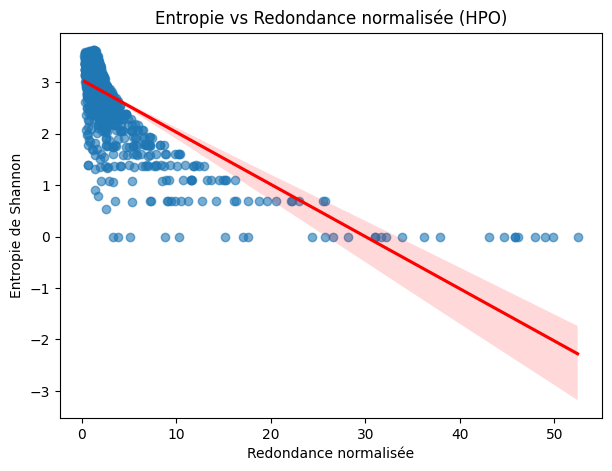

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.regplot(
    data=df,
    x="redundancy_norm",
    y="entropy_shannon",
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)
plt.xlabel("Redondance normalisée")
plt.ylabel("Entropie de Shannon")
plt.title("Entropie vs Redondance normalisée (HPO)")
plt.show()


#### KDE de l'entropie

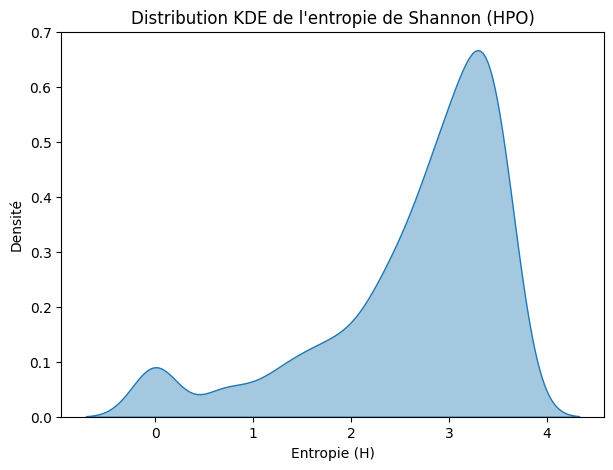

In [31]:
plt.figure(figsize=(7,5))
sns.kdeplot(
    data=df,
    x="entropy_shannon",
    fill=True,
    alpha=0.4,
)
plt.title("Distribution KDE de l'entropie de Shannon (HPO)")
plt.xlabel("Entropie (H)")
plt.ylabel("Densité")
plt.show()


#### KDE du taux de redondance normalisé

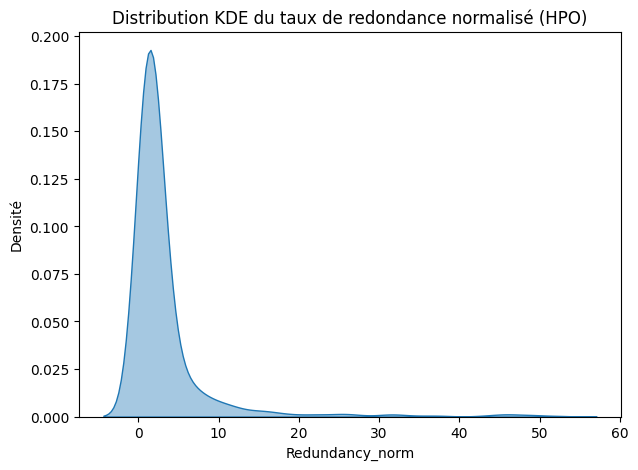

In [32]:
plt.figure(figsize=(7,5))
sns.kdeplot(
    data=df,
    x="redundancy_norm",
    fill=True,
    alpha=0.4,
)
plt.title("Distribution KDE du taux de redondance normalisé (HPO)")
plt.xlabel("Redundancy_norm")
plt.ylabel("Densité")
plt.show()


### Charge patient au service

/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_1946/4075084418.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = daily_load.resample(freq).mean()  # moyenne sur la période


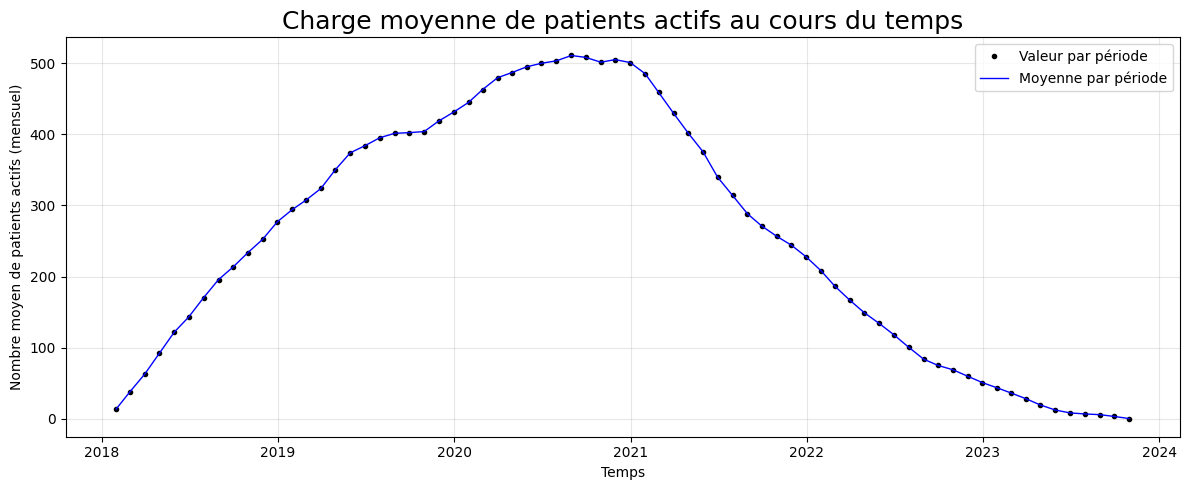

In [34]:
# --- fonction pour construire la série de charge patients ---
def build_patient_load_series(df_patients, freq='M', inclusive_last=True):
    """
    Construit une série temporelle de nombre de patients 'actifs' dans le service.

    df_patients : DataFrame niveau patient avec first_doc_date et last_doc_date (datetime)
    freq        : fréquence de resampling ('D', 'W', 'M', ...)
    inclusive_last : 
        - True  -> patient compté jusqu'au last_doc_date INCLUS (on met -1 à +1 jour)
        - False -> patient retiré le jour de last_doc_date (on met -1 à last_doc_date)
    """
    # Événements d'entrée (+1)
    start_events = (
        df_patients[["first_doc_date"]]
        .rename(columns={"first_doc_date": "date"})
        .assign(delta=1)
    )

    # Événements de sortie (-1)
    end_dates = df_patients["last_doc_date"]
    if inclusive_last:
        end_dates = end_dates + pd.Timedelta(days=1)

    end_events = (
        end_dates.to_frame(name="date")
        .assign(delta=-1)
    )

    # Concat & agrégation des événements par date
    events = (
        pd.concat([start_events, end_events], ignore_index=True)
        .groupby("date")["delta"]
        .sum()
        .sort_index()
    )

    # Cumul → nombre de patients actifs par jour
    daily_load = events.cumsum()
    daily_load.name = "n_active_patients"

    if freq is None:
        return daily_load

    # Resample à la fréquence souhaitée (ex : 'M' pour mois)
    ts = daily_load.resample(freq).mean()  # moyenne sur la période
    return ts.dropna()


def plot_time_trend(ts, title, ylabel, smooth_window=12):
    """
    ts            : Series temporelle index datetime
    smooth_window : fenêtre du lissage (en points, ex: 12 mois)
    """
    trend = ts.rolling(window=smooth_window, center=True, min_periods=1).mean()

    fig, ax = plt.subplots(figsize=(12, 5))

    # points noirs (valeurs observées)
    ax.plot(ts.index, ts.values, 'o', color='black', markersize=3, label='Valeur par période')

    # ligne bleue reliant les points
    ax.plot(ts.index, ts.values, color='blue', linewidth=1, label='Moyenne par période')

    # courbe rouge lissée
    # ax.plot(trend.index, trend.values, color='red', linewidth=2.5, label=f'Moyenne glissante ({smooth_window} périodes)')

    ax.set_title(title, fontsize=18)
    ax.set_xlabel("Temps")
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()


ts_load = build_patient_load_series(
    df,
    freq='M',             # mensuel
    inclusive_last=True   # patient compté jusqu'au dernier doc inclus
)

plot_time_trend(
    ts_load,
    title="Charge moyenne de patients actifs au cours du temps",
    ylabel="Nombre moyen de patients actifs (mensuel)",
    smooth_window=12      # lissage sur 12 mois
)


### JOINT KDE 
Super intéressant pour voir où se trouve la densité des patients par rapport à deux variables

### Le taux diagnostic au service